Throughout I will be using an API, unidbapi, to assess demographics of universities in the UK to analyse the gender split across students. The API only returns female or male, so I can only analyse that here.

### unidbapi endpoints:
Initially, we will be focussing on the following two endpoints:
- University demographics
    - https://unidbapi.com/api/university/read_demographics?u={university name}&key={API key}
    - https://unidbapi.com/api/university/read_demographics?u={university name}&key=56d0b15602
- Degree demographics
    - https://unidbapi.com/api/degree/read_demographics?d={degree}&key={API key}
    - https://unidbapi.com/api/degree/read_demographics?d={degree}&key=56d0b15602

# API Keys

In [1]:
f = open("uniDB_api.txt", "r")
api_key = f.readline() #UniDB API Key

f = open("geocode_ow_api.txt", "r")
location_api_key = f.readline() #OW API Key

# Imports

In [2]:
import pandas as pd
import requests
import json
from pprint import pprint as pp
import numpy as np
import matplotlib.pyplot as plt

# UniDB

## Methods/functions:


In [3]:
def degree_endpoint(degree):
    endpoint = "https://unidbapi.com/api/degree/read_demographics?d={}&key={}".format(degree, api_key)
    return endpoint

In [4]:
def uni_endpoint(uni):
    endpoint = "https://unidbapi.com/api/university/read_demographics?u={}&key={}".format(uni, api_key)
    return endpoint

In [5]:
def ratio_female_to_male(males, females):
    ratio = females / males
    return ratio

In [6]:
def extract_keys_to_list(dict):
    list_to_return = []
    for key in dict:
        list_to_return.append(key)

    return list_to_return

In [7]:
def extract_values_to_list(dict):
    list_to_return = []
    for item in dict:
        list_to_return.append(dict[item])

    return list_to_return

In [8]:
def remove_none_percentage(df):
    for x in df.index:
        if df.loc[x, "Percentage"] == None:
            df.drop(x, inplace = True)


In [9]:
def get_ratio_by_year_dict(degree):
    endpoint = degree_endpoint(degree)
    years = requests.get(endpoint).json()

    amount_of_years = len(years)

    ratio_by_year = {}

    i = 0

    while i < amount_of_years:
        data = years[i]
        year = data['year']
        male_grad_number = int(data['male_grads'])
        female_grad_number = int(data['female_grads'])
        ratio = ratio_female_to_male(male_grad_number, female_grad_number)
        ratio_by_year.update({ year : ratio})
        i += 1

    return ratio_by_year

In [10]:
def turn_lists_into_df(dict_ratio_by_year):
    year_list = extract_keys_to_list(dict_ratio_by_year)
    ratio_list = extract_values_to_list(dict_ratio_by_year)

    degree_by_year = {
        "Year": year_list,
        "Ratio": ratio_list
    }

    return pd.DataFrame(degree_by_year)

In [11]:
def display_as_year_barchart(year_ratios):
    year_ratios.plot(kind = 'bar', x =  'Year', y= 'Ratio')
    plt.plot([-3, 10], [1, 1], 'k-', lw=2)


## Degrees

I manually created a list of degrees from: https://www.britishuni.com/subject-guide/subject-list & https://www.open.ac.uk/courses/atoz
I also found a 'demo' page from the API: https://unidbapi.com/demo and this has a small list of potential uni's and degrees. It is not exhaustive, as I have tested unis & degrees not within this list and had valid responses. So, the contents has been added to the list

In [12]:
degrees = ['Archaeology', 'Architecture', 'Ancient History', 'Art', 'Astrophysics', 'Accounting', 'Art History',  'Arts and Humanities', 'Business', 'Business and Management', 'Computer Science', 'Creative Writing', 'Criminology', 'Chemistry', 'Classical Studies', 'Combined Studies', 'Computing and IT', 'Counselling', 'Dentistry', 'Drama', 'Dance', 'Design', ' Early Years', 'Economics', 'Education', 'Engineering', 'Electrical Engineering', 'Electronic Engineering', 'Environment', 'Environmental Studies', 'Biology', 'French', 'Mathematics', 'English', 'Film and Media', 'Journalism', 'Geology', 'Geography', 'Health and Social Care', 'Health and Wellbeing', 'Health Sciences', 'History', 'International Business', 'International Studies', 'Languages', 'Literature', 'Latin', 'Law', 'Music', 'Marketing', 'Mental Health', 'Music', 'Midwifery', 'Nursing', 'Nursing and Healthcare', 'Philosophy','Physics', 'Politics','Psychology','Religion', 'Religious Studies', 'Science', 'Sociology', 'Social Care', 'Social Sciences', 'Social Work', 'Sociology', 'Software Engineering', 'Sport & Fitness', 'Statistics', 'Natural Sciences', 'Media and Communication', 'Hospitality', 'Medicine', 'Marine Biology', 'Astonomy', 'Mechanical Engineering', 'Politics', 'Anthropology', 'Medical Science', 'Agriculture']


valid_degrees = []

Find the degrees that return results in the API

In [13]:
for degree in degrees:
    response = requests.get(degree_endpoint(degree))
    if json.dumps(response.json()) != "{\"error\": \"Invalid Query\"}":
        valid_degrees.append(degree)

In [14]:
degree_average_ratio = {}

Now that we have a list of degrees that are in the API's 'system', we can begin reading the API for data.

The degrees end point returns the following, multiple times (e.g. 4x, presumably for each university record that matches this degree? :
- "degree": {degree as a string},
- "male_grads": "number as a string",
- "female_grads": "number as a string",
- "year": {as a string}

In [15]:
for degree in valid_degrees:
    endpoint = degree_endpoint(degree)
    lists = requests.get(endpoint).json()

    amount_of_data = len(lists)

    ratios_for_this_degree = []

    i = 0
    while i < amount_of_data:
        data = lists[i]
        male_grad_number = int(data['male_grads'])
        female_grad_number = int(data['female_grads'])
        ratio = ratio_female_to_male(male_grad_number, female_grad_number)
        ratios_for_this_degree.append(ratio)
        i += 1

    arr = np.array(ratios_for_this_degree)
    degree_average = np.average(arr)
    degree_average_ratio.update({degree : degree_average})


In [16]:
print(degree_average_ratio)

{'Architecture': 0.6667655162233832, 'Computer Science': 0.2401670612170872, 'Biology': 1.674302568808816, 'Mathematics': 0.6377244698420046, 'History': 1.1608471190994043, 'Law': 1.5871251581299277, 'Medical Science': 3.7984104598084487, 'Agriculture': 1.8206130790914017}


## Data Analysis

For a pandas dataframe, need dictionary where the key is the column name, and the values are an array
We now have the following collated data:
- degree_average_ratio
    - average ratio of women : men per degree
    - e.g. 1.7 = 1.7 women per 1 man, 0.6 = 0.6 women per 1 man

For each of the above, we need a list of the values and a list of the keys in the same order. Then we can make a pandas dataframe


In [17]:
degree_avg_ratio_degree_list = extract_keys_to_list(degree_average_ratio)
degree_avg_ratio_ratio_list = extract_values_to_list(degree_average_ratio)

In [18]:
print(degree_avg_ratio_ratio_list)

[0.6667655162233832, 0.2401670612170872, 1.674302568808816, 0.6377244698420046, 1.1608471190994043, 1.5871251581299277, 3.7984104598084487, 1.8206130790914017]


In [19]:
female_ratio_data = {
    "Degree": degree_avg_ratio_degree_list,
    "Ratio": degree_avg_ratio_ratio_list
}

In [20]:
df_ratio = pd.DataFrame(female_ratio_data)
print(df_ratio)

             Degree     Ratio
0      Architecture  0.666766
1  Computer Science  0.240167
2           Biology  1.674303
3       Mathematics  0.637724
4           History  1.160847
5               Law  1.587125
6   Medical Science  3.798410
7       Agriculture  1.820613


Bar chart showing ratio of women:men on courses. Horizontal line indicates 1:1.
lowest results are for Maths and Comp Sci

Text(0.5, 1.0, 'Ratio of males to females \n by degree between 2014 - 2018')

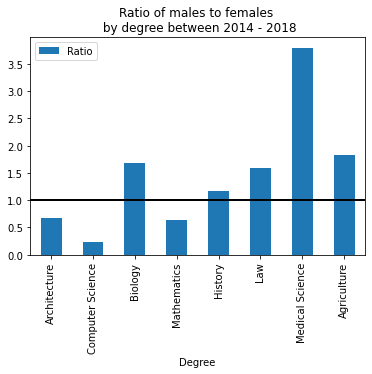

In [21]:

df_ratio.plot(kind = 'bar', x =  'Degree', y= 'Ratio')
plt.plot([-3, 10], [1, 1], 'k-', lw=2) #horizontal line for 1:1
plt.title("Ratio of males to females \n by degree between 2014 - 2018")

In [22]:
df_ratio_avg = df_ratio["Ratio"].mean()
print(df_ratio_avg)

1.4482444290275591


I have seen that the API endpoint returns the same degree over several years. Now that I have performed an overall analysis, as the range of degrees is relatively small, I shall analyse each degree per year.

### degree = maths

In [23]:
math_ratio_by_year_dict = get_ratio_by_year_dict('Mathematics')

In [24]:
math_year_ratios = turn_lists_into_df(math_ratio_by_year_dict)
print(math_year_ratios)

   Year     Ratio
0  2014  0.652083
1  2015  0.640698
2  2016  0.642125
3  2017  0.638471
4  2018  0.615244


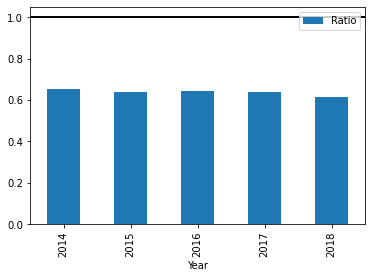

In [25]:
display_as_year_barchart(math_year_ratios)

Average value

In [26]:
math_by_year = extract_values_to_list(math_ratio_by_year_dict)
average_math = sum(math_by_year) / len(math_by_year)
print(average_math)

0.6377244698420046


roughly predict growth models at the current rate:
_not using machine learning as not enough data, may cause underfitting_

In [27]:
four_year_change = math_by_year[4] - math_by_year[0]
print(four_year_change)

-0.03683943089430897


As the change is negative, it is not possible at the current growth rate o increase to a ratio of 1.

### degree = Architecture

In [28]:

architecture_ratio_by_year_dict = get_ratio_by_year_dict('Architecture')

In [29]:

architecture_year_ratios = turn_lists_into_df(architecture_ratio_by_year_dict)
print(architecture_year_ratios)

   Year     Ratio
0  2014  0.608538
1  2015  0.646432
2  2016  0.666667
3  2017  0.686292
4  2018  0.725900


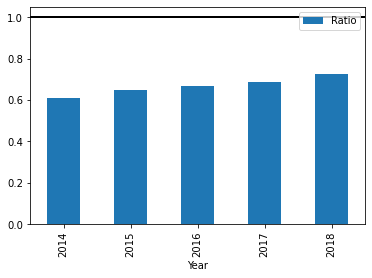

In [30]:

display_as_year_barchart(architecture_year_ratios)

### degree = computer science

In [31]:
compsci_ratio_by_year_dict = get_ratio_by_year_dict('Computer Science')

In [32]:
compsci_year_ratios = turn_lists_into_df(compsci_ratio_by_year_dict)
print(compsci_year_ratios)

   Year     Ratio
0  2014  0.239120
1  2015  0.242881
2  2016  0.233533
3  2017  0.235744
4  2018  0.249558


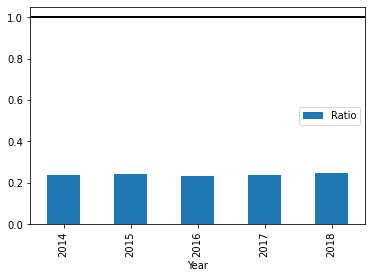

In [33]:
display_as_year_barchart(compsci_year_ratios)

In [34]:
comp_by_year = extract_values_to_list(compsci_ratio_by_year_dict)
average_comp_sci = sum(comp_by_year) / len(comp_by_year)

print(average_comp_sci)

0.2401670612170872


roughly predict growth models at the current rate:
_not using machine learning as not enough data, may cause underfitting_

In [35]:
four_year_change = comp_by_year[4] - comp_by_year[0]
print(four_year_change)

0.010437151753523444


Changing by 0.010437151753523444 every four years, the increase from a current of 0.249558:

In [36]:
value_2018 = 0.249558
four_year_inc = 0.010437151753523444
change_to_be_made_to_get_to_one_to_one = 1 - value_2018
amount_of_four_years_to_change = change_to_be_made_to_get_to_one_to_one / four_year_inc
print(4 * amount_of_four_years_to_change)

287.60413481452383


### Degree = 'Biology'

   Year     Ratio
0  2014  1.600216
1  2015  1.568395
2  2016  1.615935
3  2017  1.738482
4  2018  1.848485


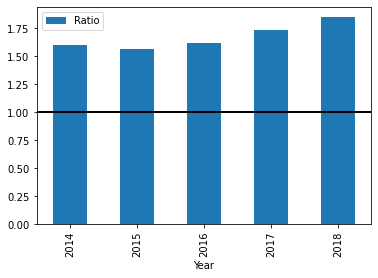

In [37]:
biology_ratio_by_year_dict = get_ratio_by_year_dict('Biology')

biology_year_ratios = turn_lists_into_df(biology_ratio_by_year_dict)
print(biology_year_ratios)

display_as_year_barchart(biology_year_ratios)

### Degree = History

   Year     Ratio
0  2014  1.127883
1  2015  1.140799
2  2016  1.148148
3  2017  1.183299
4  2018  1.204107


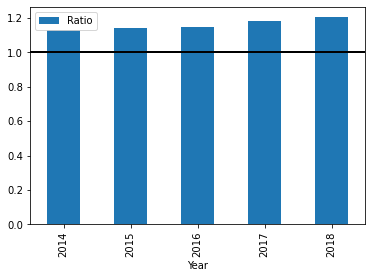

In [38]:
history_ratio_by_year_dict = get_ratio_by_year_dict('History')

history_year_ratios = turn_lists_into_df(history_ratio_by_year_dict)
print(history_year_ratios)

display_as_year_barchart(history_year_ratios)

### Degree = Law

   Year     Ratio
0  2014  1.526082
1  2015  1.545051
2  2016  1.545051
3  2017  1.602585
4  2018  1.716858


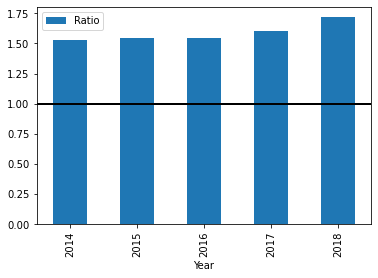

In [39]:
law_ratio_by_year_dict = get_ratio_by_year_dict('Law')

law_year_ratios = turn_lists_into_df(law_ratio_by_year_dict)
print(law_year_ratios)

display_as_year_barchart(law_year_ratios)

### Degree = Medical Science

   Year     Ratio
0  2014  3.911880
1  2015  3.799526
2  2016  3.726893
3  2017  3.799610
4  2018  3.754144


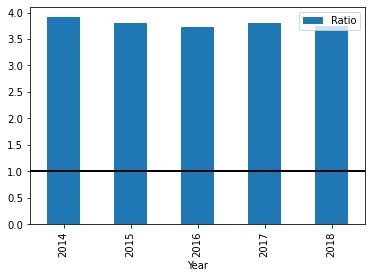

In [40]:
medSci_ratio_by_year_dict = get_ratio_by_year_dict('Medical Science')

medSci_year_ratios = turn_lists_into_df(medSci_ratio_by_year_dict)
print(medSci_year_ratios)

display_as_year_barchart(medSci_year_ratios)

The average value over the years:

In [41]:
medical_by_year = extract_values_to_list(medSci_ratio_by_year_dict)
average_med_sci = sum(medical_by_year) / len(medical_by_year)

print(average_med_sci)

3.7984104598084487


### Degree = Agriculture

   Year     Ratio
0  2014  1.585837
1  2015  1.700229
2  2016  1.875878
3  2017  1.873206
4  2018  2.067916


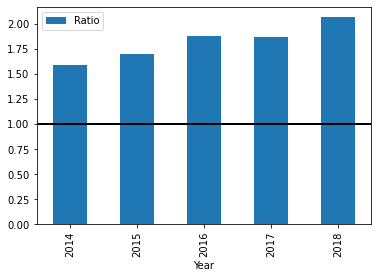

In [42]:
agri_ratio_by_year_dict = get_ratio_by_year_dict('Agriculture')

agri_year_ratios = turn_lists_into_df(agri_ratio_by_year_dict)
print(agri_year_ratios)

display_as_year_barchart(agri_year_ratios)

Lets compare all degrees together

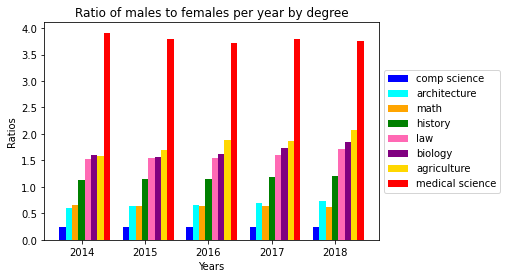

In [43]:
x = np.arange(5)
architecture_bars = extract_values_to_list(architecture_ratio_by_year_dict)
math_bars = extract_values_to_list(math_ratio_by_year_dict)
comp_sci_bars = extract_values_to_list(compsci_ratio_by_year_dict)
biology_bars = extract_values_to_list(biology_ratio_by_year_dict)
history_bars = extract_values_to_list(history_ratio_by_year_dict)
law_bars = extract_values_to_list(law_ratio_by_year_dict)
medical_bars = extract_values_to_list(medSci_ratio_by_year_dict)
agri_bars = extract_values_to_list(agri_ratio_by_year_dict)
width = 0.1

# plot data in grouped manner of bar type
plt.bar(x-0.3, comp_sci_bars, width, color='blue')
plt.bar(x-0.2, architecture_bars, width, color='cyan')
plt.bar(x-0.1, math_bars, width, color='orange')
plt.bar(x, history_bars, width, color='green')
plt.bar(x+0.1, law_bars, width, color='hotpink')
plt.bar(x+0.2, biology_bars, width, color='purple')
plt.bar(x+0.3, agri_bars, width, color='gold')
plt.bar(x+0.4, medical_bars, width, color='red')
plt.xticks(x, ['2014', '2015', '2016', '2017', '2018'])
plt.xlabel("Years")
plt.ylabel("Ratios")
plt.legend(["comp science", "architecture", "math", "history", "law", "biology", "agriculture", "medical science"], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Ratio of males to females per year by degree")

plt.show()

Lets plot all degrees on a scatter diagram - to do this we make a dataframe with all degrees - to see the trends in better detail

In [44]:
year_list = extract_keys_to_list(math_ratio_by_year_dict) #can be any, all the same
architec_year_list = extract_values_to_list(architecture_ratio_by_year_dict)
compSci_year_list = extract_values_to_list(compsci_ratio_by_year_dict)
biology_year_list = extract_values_to_list(biology_ratio_by_year_dict)
math_year_ratios = extract_values_to_list(math_ratio_by_year_dict)
history_year_list = extract_values_to_list(history_ratio_by_year_dict)
law_year_list = extract_values_to_list(law_ratio_by_year_dict)
medSci_year_list = extract_values_to_list(medSci_ratio_by_year_dict)
agric_year_list = extract_values_to_list(agri_ratio_by_year_dict)

all_degrees_by_year = {
    "Year": year_list,
    "Architecture" : architec_year_list,
    "Computer Science": compSci_year_list,
    "Biology":biology_year_list,
    "Mathematics": math_year_ratios,
    "History" : history_year_list,
    "Law": law_year_list,
    "Medical Science": medSci_year_list,
    "Agriculture": agric_year_list
}

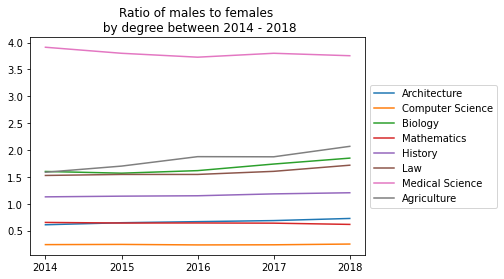

In [45]:
df_years = pd.DataFrame(all_degrees_by_year)

df_years.plot()
plt.title("Ratio of males to females \n by degree between 2014 - 2018")
plt.xticks(x, ['2014', '2015', '2016', '2017', '2018'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Universities


I have manually created a list of UK universities by extracting the names from an online list: https://www.university-list.net/uk/universities-1000.html & https://www.jeduka.com/articles-updates/uk/list-of-top-100-ranking-universities-in-uk
As above, I have also added in the small amount from the Demo.
To try and get accurate representation of the population, have included all ’University of’s

In [46]:
unis = [ 'Anglia Ruskin University', 'Coventry University', 'Newcastle University', 'Royal Veterinary College', 'The Open University', 'The University of Essex', 'The University of Kent', 'The University of Manchester', 'The University of Surrey', 'University of Birmingham', 'University of Bristol', 'University of Nottingham', 'Writtle University College', 'University of Bath', 'Bishop Grosseteste College', 'University of Bolton', 'Bournemouth University', 'The Arts University College at Bournemouth', 'The University of Bradford', 'Bretton Hall College', 'University of Brighton', 'University of Bristol', 'University of the West of England', 'Brunel University London', 'The University of Buckingham', 'Cambridge University', 'The University of Cambridge', 'Cannington College', 'Canterbury Christ Church University',  'University of Bedfordshire', 'University of Chester', 'University of Cumbria', 'University of  Derby', 'University of East Anglia', 'University of East London', 'University of Essex', 'University of Gloucestershire', 'University of Greenwich', 'University of Hertfordshire', 'University of Huddersfield', 'University of Hull', 'University of Kent', 'University of Central Lancashire', 'University of Leeds', 'University of Leicester', 'University of Lincoln', 'University of Liverpool', 'University of London', 'University of Northampton', 'University of  Oxford', 'University of Plymouth', 'University of Portsmouth', 'University of Reading', 'University of Salford', 'University of Sheffield', 'University of Southampton', 'University of Suffolk', 'University of Sunderland', 'University of Sussex', 'University of Law', 'University of Warwick', 'University of West London', 'University of Westminster', 'University of Winchester', 'University of Wolverhampton', 'University of Worcester', 'University of York']
valid_unis = []
invalid_unis = []

Determine which of the above are valid for the API

In [47]:
for uni in unis:
    endpoint = uni_endpoint(uni)
    response = requests.get(endpoint)
    if json.dumps(response.json()) != "{\"error\": \"Invalid Query\"}":
        valid_unis.append(uni)
    else:
        invalid_unis.append(uni)

sometimes universities are referenced with 'The' infront of the name. So, to ensure we check as many as possible, I will also check with a 'the' infront:
uni of liverpool vs liverpool university

could perhaps try removing 'the' too in future studies

In [48]:
for unis in invalid_unis:
    try_the = 'The ' + uni
    endpoint = "https://unidbapi.com/api/university/read_demographics?u={}&key={}".format(try_the, api_key)
    response = requests.get(endpoint)
    if json.dumps(response.json()) != "{\"error\": \"Invalid Query\"}":
        valid_unis.append(try_the)

In [49]:
print(valid_unis)

['Anglia Ruskin University', 'Coventry University', 'Newcastle University', 'Royal Veterinary College', 'The Open University', 'The University of Essex', 'The University of Kent', 'The University of Manchester', 'The University of Surrey', 'University of Birmingham', 'University of Bristol', 'University of Nottingham', 'Writtle University College', 'University of Bath', 'Bishop Grosseteste College', 'University of Bolton', 'Bournemouth University', 'The Arts University College at Bournemouth', 'The University of Bradford', 'Bretton Hall College', 'University of Brighton', 'University of Bristol', 'University of the West of England', 'Brunel University London', 'The University of Buckingham', 'Cambridge University', 'The University of Cambridge', 'Cannington College', 'Canterbury Christ Church University', 'University of Bedfordshire', 'University of Chester', 'University of Cumbria', 'University of  Derby', 'University of East Anglia', 'University of East London', 'University of Essex'

In [50]:
print(len(valid_unis))

67


Now that we have a list of universities that are in the API's 'system', we can begin reading the API for data.

The university endpoint returns the following once:
- "name": "Anglia Ruskin University",
- "male_grads": "36",
- "female_grads": "64",
- "male_staff": "60",
- "female_staff": "40",
- "year": "2020"

all university demographic responses have 6 responses, so I will extract the female_grads, and female_staff.

Although we are assessing education, as there is the data available for percentage of staff that are female, I will perform the same analysis to see if there is any correlation.

In [51]:
female_grad_percentage_per_uni = {}
female_staff_percentage_per_uni = {}

In [52]:
for university in valid_unis:
    endpoint = uni_endpoint(university)
    data = requests.get(endpoint).json()
    # adding to a list without converting to int prior, as some return 'none' if data is missing
    #pp(data)
    female_grad_percentage_per_uni.update({university : data['female_grads']})
    female_staff_percentage_per_uni.update({university : data['female_staff']})


For a pandas dataframe, need dictionary where the key is the column name, and the values are an array
We now have the following collated data:
- female_staff_percentage_per_uni
- female_grad_percentage_per_uni

For each of the above, we need a list of the values and a list of the keys in the same order. Then we can make a pandas dataframe

In [53]:
female_staff_percentage_list = extract_values_to_list(female_staff_percentage_per_uni)
female_staff_uni_name_list = extract_keys_to_list(female_staff_percentage_per_uni)
female_grad_percentage_list = extract_values_to_list(female_grad_percentage_per_uni)
female_grad_uni_name_list = extract_keys_to_list(female_grad_percentage_per_uni)

In [54]:
print(female_staff_percentage_list)

['40', '46', '46', '31', '39', '44', '44', '50', '47', '47', '45', '47', '32', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '46', '43', None, None, None, None, None, None, '46', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [55]:
print(female_grad_percentage_list)

['64', '48', '15', '79', '61', '55', '53', '54', '54', '58', '56', '54', '79', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '59', '58', None, None, None, None, None, None, '55', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


From the above, it is apparent that further data cleansing is needed for the University endpoint generated data (percentages). As, although the request was valid, 'none' has been returned. I will make this into a pandas dataframe first however, as I can then use pandas method to remove corrupted data.

In [56]:
female_grad_data = {
    "University": female_grad_uni_name_list,
    "Percentage": female_grad_percentage_list
}

In [57]:
df_grads = pd.DataFrame(female_grad_data)
print(df_grads)

                     University Percentage
0      Anglia Ruskin University         64
1           Coventry University         48
2          Newcastle University         15
3      Royal Veterinary College         79
4           The Open University         61
..                          ...        ...
61    University of Westminster       None
62     University of Winchester       None
63  University of Wolverhampton       None
64      University of Worcester       None
65           University of York       None

[66 rows x 2 columns]


In [58]:
female_staff_data = {
    "University": female_staff_uni_name_list,
    "Percentage": female_staff_percentage_list
}

df_staff = pd.DataFrame(female_staff_data)
print(df_staff)

                     University Percentage
0      Anglia Ruskin University         40
1           Coventry University         46
2          Newcastle University         46
3      Royal Veterinary College         31
4           The Open University         39
..                          ...        ...
61    University of Westminster       None
62     University of Winchester       None
63  University of Wolverhampton       None
64      University of Worcester       None
65           University of York       None

[66 rows x 2 columns]


Now for the data cleansing of the staff & grad data, we create a cleaning method

In [59]:
remove_none_percentage(df_staff)
remove_none_percentage(df_grads)

In [60]:
print(df_staff)
print(df_grads)

                      University Percentage
0       Anglia Ruskin University         40
1            Coventry University         46
2           Newcastle University         46
3       Royal Veterinary College         31
4            The Open University         39
5        The University of Essex         44
6         The University of Kent         44
7   The University of Manchester         50
8       The University of Surrey         47
9       University of Birmingham         47
10         University of Bristol         45
11      University of Nottingham         47
12    Writtle University College         32
36       University of Greenwich         46
37   University of Hertfordshire         43
44         University of Lincoln         46
                      University Percentage
0       Anglia Ruskin University         64
1            Coventry University         48
2           Newcastle University         15
3       Royal Veterinary College         79
4            The Open University

These datasets are now cleaned of percentage with 'None', and can be analysed once the datatype has migrated.

In [61]:
df_staff = df_staff.astype({'Percentage':'int'})
df_grads = df_grads.astype({'Percentage':'int'})

Firstly, the grads gender percentages:
Horizontal line to show 50/50 split

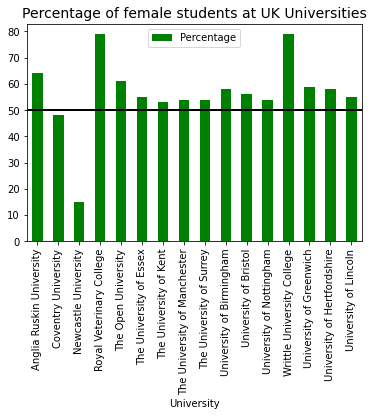

In [62]:
df_grads.plot(kind = 'bar', x =  'University', y= 'Percentage', color="green")
plt.plot([-3, 30], [50, 50], 'k-', lw=2)

plt.title("Percentage of female students at UK Universities", size=14)

plt.show()

Shows the majority of grads across universities are female


In [63]:
df_grad_avg = df_grads["Percentage"].mean()
print(df_grad_avg)

56.375


Next, the staff:

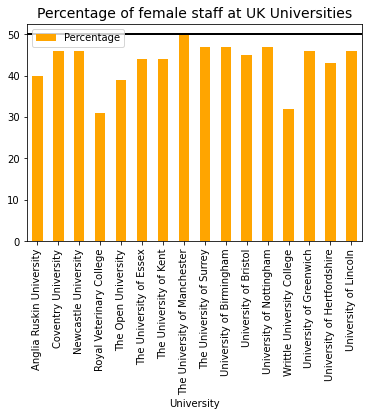

In [75]:
df_staff.plot(kind = 'bar', x =  'University', y= 'Percentage', color="orange")
plt.plot([-3, 30], [50, 50], 'k-', lw=2)
plt.title("Percentage of female staff at UK Universities", size=14)

plt.show()

This shows a lower split, meaning there are on average more male staff members.

In [65]:
df_staff_avg = df_staff["Percentage"].mean()
print(df_staff_avg)

43.3125


Lets compare the staff vs students at each university:

In [69]:
len(df_staff.index)
len(df_grads.index)

16

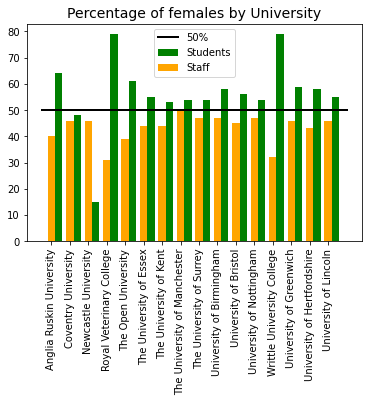

In [77]:
x = np.arange(16)
grad_bars = df_grads['Percentage']
staff_bars = df_staff['Percentage']

width = 0.4

plt.bar(x+0.4, grad_bars, width, color='green')
plt.bar(x, staff_bars, width, color='orange')
plt.plot([-0.5, 16], [50, 50], 'k-', lw=2)

plt.xticks(x, df_staff['University'].values.tolist())
plt.xticks(rotation = 90)

plt.legend(["50%", "Students", "Staff"])
plt.title("Percentage of females by University", size=14)

plt.show()

# Geocoding - OW API

Documentation: https://openweathermap.org/api/geocoding-api

## Methods & resources

A list of english cities, may be used to map the uk or places to their closest city. Obtained manually from https://www.britannica.com/topic/list-of-cities-and-towns-in-the-United-Kingdom-2034188

In [78]:
list_english_cities = ['Newcastle upon Tyne', 'Durham', 'York', 'Leeds', 'Manchester', 'Hull', 'Nottingham', 'Leicester', 'Skegness', 'Peterborough', 'Cambridge', 'Northampton', 'Liverpool', 'Chester',   'Plymouth', 'Exeter', 'Plymouth', 'Bournemouth', 'Brighton', 'Hastings', 'Catebury', 'London', 'Colchester', 'Manchester', 'Ipswich', 'Luton', 'Northampton', 'Oxford', 'Swindon', 'Birmingham', 'Whitby', 'Bristol']

In [79]:
def city_endpoint(city):
    endpoint = "http://api.openweathermap.org/geo/1.0/direct?q={},GB&appid={}".format(city, location_api_key)
    return endpoint

In [80]:
def get_city_api_data(city):
    endpoint = city_endpoint(city)
    response = requests.get(endpoint).json()
    return response

In [81]:
def get_lon_of_city(place):
    results = get_city_api_data(place)
    if len(results) == 1:
        city_results = results[0]
        lon_to_return = city_results['lon']
    else:
        i = 0
        city_in_uk = False
        while not city_in_uk:
            city_to_try = results[i]
            if city_to_try['country'] == 'GB':
                city_in_uk = True
            i+= 1
        lon_to_return = city_to_try['lon']
    return lon_to_return


In [82]:
def get_lat_of_city(place):
    results = get_city_api_data(place)
    if len(results) == 1:
        city_results = results[0]
        lat_to_return = city_results['lat']
    else:
        i = 0
        city_in_uk = False
        while not city_in_uk:
            city_to_try = results[i]
            if city_to_try['country'] == 'GB':
                city_in_uk = True
            i+= 1
        lat_to_return = city_to_try['lat']
    return lat_to_return


Lat/long conversions
one degree longitude equals 288,200 feet (54.6 miles)
one degree latitude equals approximately 364,000 feet (69 miles),

In [83]:
 # 1 degree = 54.6 miles
# 1 mile = 1/54.6 degrees

def miles_to_lon(miles):
    conversion = 1.0 / 54.60
    return miles * conversion

#similarly for latitude

def miles_to_lat(miles):
    conversion = 1.0 / 69.0
    return miles * conversion

def lat_to_miles(lat):
    return lat * 69.0

def long_to_miles(lon):
    return lon * 54.60

In [84]:
cities = []
lons = []
lats = []

def add_city_details_to_list(list_to_check):
    if len(list_to_check) == 1:
        city_list = list_to_check[0]
        lat = city_list['lat']
        lon = city_list['lon']
        cities.append(city)
        lons.append(lon)
        lats.append(lat)


Coordinates for major cities to display on maps: obtained from maps, just picked reference cities at various latitudes

In [85]:
#coordinates
x = np.array([-4, 4]) #for horizontal line
y = np.array([50, 58]) #vertical line
y_lon = np.array([51.5072, 51.5072]) #london
x_lon = np.array([0.1276, 0.1276]) #london
y_manchester = np.array([53.4808,53.4808])
x_manchester = np.array([-2.2426, -2.2426])
y_newcastle = np.array([54.9783,54.9783])
y_edinburgh = np.array([55.48, 55.48]) #northernmost point of England
y_plymouth = np.array([50.3755, 50.3755])

The below methods were not used in the end,  but are to plot the lines for major cities as map references/markers

In [86]:
def plot_major_cities():
    plt.plot(x, y_newcastle, color="aqua", label="newcastle")
    plt.plot(x, y_manchester, color="orange", label="manchester")
    plt.plot(x_manchester, y, color="orange")
    plt.plot(x, y_lon, color="hotpink", label="london")
    plt.plot(x_lon, y, color="hotpink")
    plt.plot(x, y_plymouth, color="red", label="plymouth")
    plt.legend(loc="upper right")

In [87]:
def plot_major_cities_no_legend():
    plt.plot(x, y_newcastle, color="aqua", label="newcastle")
    plt.plot(x, y_manchester, color="orange", label="manchester")
    plt.plot(x_manchester, y, color="orange")
    plt.plot(x, y_lon, color="hotpink", label="london")
    plt.plot(x_lon, y, color="hotpink")
    plt.plot(x, y_plymouth, color="red", label="plymouth")

In [88]:
def plot_man_lon():
    plt.plot(x, y_manchester, color="orange", label="manchester")
    plt.plot(x_manchester, y, color="orange")
    plt.plot(x, y_lon, color="hotpink", label="london")
    plt.plot(x_lon, y, color="hotpink")
    plt.legend(["Universities", "Manchester", "", "London"])

In [89]:
def plot_man_lon_no_legend():
    plt.plot(x, y_manchester, color="orange", label="manchester")
    plt.plot(x_manchester, y, color="orange")
    plt.plot(x, y_lon, color="hotpink", label="london")
    plt.plot(x_lon, y, color="hotpink")

In [90]:
def create_no_dupe_list(list_to_check):
    unduped_list = []
    for item in list_to_check:
        occurences = list_to_check.count(item)
        if occurences == 1:
            unduped_list.append(item)

    return unduped_list

### Data cleansing/sorting/organising

In [91]:
list_english_cities.sort()
print(list_english_cities)

['Birmingham', 'Bournemouth', 'Brighton', 'Bristol', 'Cambridge', 'Catebury', 'Chester', 'Colchester', 'Durham', 'Exeter', 'Hastings', 'Hull', 'Ipswich', 'Leeds', 'Leicester', 'Liverpool', 'London', 'Luton', 'Manchester', 'Manchester', 'Newcastle upon Tyne', 'Northampton', 'Northampton', 'Nottingham', 'Oxford', 'Peterborough', 'Plymouth', 'Plymouth', 'Skegness', 'Swindon', 'Whitby', 'York']


Can visibly see duplicates, e.g. Manchester, so shall now remove them

In [92]:
clean_english_cities_list = create_no_dupe_list(list_english_cities)

In [93]:
print(list_english_cities)

['Birmingham', 'Bournemouth', 'Brighton', 'Bristol', 'Cambridge', 'Catebury', 'Chester', 'Colchester', 'Durham', 'Exeter', 'Hastings', 'Hull', 'Ipswich', 'Leeds', 'Leicester', 'Liverpool', 'London', 'Luton', 'Manchester', 'Manchester', 'Newcastle upon Tyne', 'Northampton', 'Northampton', 'Nottingham', 'Oxford', 'Peterborough', 'Plymouth', 'Plymouth', 'Skegness', 'Swindon', 'Whitby', 'York']


In [94]:
len(list_english_cities)

32

In [95]:
len(clean_english_cities_list)

26

In [96]:
print(clean_english_cities_list)

['Birmingham', 'Bournemouth', 'Brighton', 'Bristol', 'Cambridge', 'Catebury', 'Chester', 'Colchester', 'Durham', 'Exeter', 'Hastings', 'Hull', 'Ipswich', 'Leeds', 'Leicester', 'Liverpool', 'London', 'Luton', 'Newcastle upon Tyne', 'Nottingham', 'Oxford', 'Peterborough', 'Skegness', 'Swindon', 'Whitby', 'York']


Can also see spelling errors, check which will successfully call API

In [97]:
for city in clean_english_cities_list:
    print(city)
    print(get_city_api_data(city))

Birmingham
[{'name': 'Birmingham', 'local_names': {'oc': 'Birmingham', 'fa': 'بیرمنگام', 'bg': 'Бирмингам', 'ur': 'برمنگھم', 'pt': 'Birmingham', 'az': 'Birmingem', 'la': 'Birminghamia', 'hi': 'बर्मिंघम', 'kn': 'ಬರ್ಮಿಂಗ್ಹ್ಯಾಮ್', 'ru': 'Бирмингем', 'my': 'ဘာမင်ဂမ်မြို့', 'en': 'Birmingham', 'zh': '伯明翰', 'bn': 'বার্মিংহাম', 'ta': 'பர்மிங்காம் (ஐக்கிய இராச்சியம்)', 'th': 'เบอร์มิงแฮม', 'sr': 'Бирмингем', 'hy': 'Բիրմինգհեմ', 'el': 'Μπέρμιγχαμ', 'uk': 'Бірмінгем', 'pa': 'ਬਰਮਿੰਘਮ', 'ml': 'ബിർമിങ്ഹാം', 'te': 'బర్మింగ్\u200cహామ్', 'ka': 'ბირმინგემი', 'gu': 'બર્મિંગહામ', 'lv': 'Birmingema', 'mk': 'Бирмингем', 'yi': 'בירמינגהאם', 'ug': "Birmin'gxam", 'he': 'ברמינגהאם', 'lt': 'Birmingamas', 'be': 'Бірмінгем', 'mr': 'बर्मिंगहॅम', 'hu': 'Birmingham', 'ja': 'バーミンガム', 'ar': 'برمنهام', 'am': 'በርሚንግሃም', 'ko': '버밍엄'}, 'lat': 52.4796992, 'lon': -1.9026911, 'country': 'GB', 'state': 'England'}]
Bournemouth
[{'name': 'Bournemouth', 'local_names': {'ru': 'Борнмут', 'sr': 'Борнмут', 'en': 'Bournemouth', 'ko':

Can see Cantebury doesn't work, as spelt incorrectly, and Cork has no results - will update & remove


In [98]:
clean_english_cities_list.remove("Catebury")
clean_english_cities_list.append("Canterbury")

In [99]:
print(len(clean_english_cities_list))

26


double check Cantebury now calls API successfully & changed succesfully

In [100]:
if "Canterbury" in clean_english_cities_list:
    print("successful")
    print(get_city_api_data("Canterbury"))

successful
[{'name': 'Canterbury', 'local_names': {'lt': 'Kenterberis', 'ar': 'كانتربيري', 'ko': '캔터베리', 'pt': 'Cantuária', 'sr': 'Кентербери', 'uk': 'Кентербері', 'ru': 'Кентербери', 'mk': 'Кантербери', 'lv': 'Kanterburija', 'hu': 'Canterbury', 'br': 'Canterbury', 'fr': 'Cantorbéry', 'cy': 'Caergaint', 'la': 'Cantuaria', 'en': 'Canterbury'}, 'lat': 51.2800275, 'lon': 1.0802533, 'country': 'GB', 'state': 'England'}]


Confident that this has now been cleaned

### Using Geocoding to find the nearest city
In the end, this function was not used. It was intended to allow us to assign universities to a nearby major city, adjusting the distance and list of cities 'accepted' above. This was not used, as we can obtain the city of the university directly from the API. However, in future studies this may be used for deeper analysis, perhaps using a dataset from the government rather than just the API.

obtaining lats/lons of cities in clean_english_cities_lists

In [101]:
#ensure clean prior to use
lats = []
lons = []
for city in clean_english_cities_list:
    list_to_add = get_city_api_data(city)
    add_city_details_to_list(list_to_add)


ensure all have been added correctly, no duplicates etc

In [102]:
print(len(lats))
print(len(clean_english_cities_list))
print(len(lons))

26
26
26


We now have ordered lists of the uk cities with their lon&lats
now we create a method to find the nearest city based on lat& lons

assumptions to make
Northernmost point – Marshall Meadows Bay, Northumberland at 55°48′N 2°02′W (55.8, -2.033333)
Southernmost point – Pednathise Head, Western Rocks at 49°51′N 6°24′W (49.85, -6.4)
Westernmost point – Crim Rocks, Isles of Scilly at 49°53′N 6°27′W (49.883333, -6.45)
Easternmost point – Lowestoft Ness, Suffolk at 52°29′N 1°46′E (52.483333, 1.766667)

(lat, lon)
Uk lats always positive, lons can be positive or negative. To allow for easier analysis, will scale the lons to be positive (this does not affect analysis, but if using the lons later will need to re-scale back

The method to find the nearest city is not 100% accurate, as in it has not used the optimal way to find a nearest city. That was not the goal of this report, and it was just for representational purposes. Further studies would refine this.

In [111]:
#all larger than -10, will just add 10 to all to bring positive
lon_plus_ten = []

for lon in lons:
    to_add = lon + 10.00
    lon_plus_ten.append(to_add)

In [112]:
def find_nearest_city(city):
    if city in list_english_cities:
        answer = city
    else:
        city = 'Newark' #to be deleted
        response = get_city_api_data(city)
        data = response[0]

        this_latitude = data['lat']
        this_longitutde = data['lon'] + 10.00

        potential_cities = []
        potential_cities_lats_diff = {}
        potential_cities_lons_diff = {}

        for city in clean_english_cities_list:
            index = clean_english_cities_list.index(city)
            max_lat = lats[index] + miles_to_lat(50)
            min_lat = lats[index] - miles_to_lat(50)
            max_lon = lon_plus_ten[index] + miles_to_lon(50)
            min_lon = lon_plus_ten[index] - miles_to_lon(50)

            if this_latitude <= max_lat and this_latitude >= min_lat and this_longitutde <= max_lon and this_longitutde >= min_lon:
                potential_cities.append(city)
                lat_diff = this_latitude - lats[index]
                lon_diff = this_longitutde - lons[index]
                if lat_diff < 0:
                    lat_diff = -lat_diff
                if lon_diff < 0:
                    lon_diff = - lon_diff
                potential_cities_lats_diff[city] = lat_diff
                potential_cities_lons_diff[city] = lon_diff

        print(potential_cities)
        print(potential_cities_lats_diff)

        if len(potential_cities) == 1:
            answer = potential_cities[0]
        else:
            lat_city_list = extract_keys_to_list(potential_cities_lats_diff)
            lat_diff_list = extract_values_to_list(potential_cities_lats_diff)
            lon_city_list = extract_keys_to_list(potential_cities_lons_diff)
            lon_diff_list = extract_values_to_list(potential_cities_lons_diff)
            smallest_lat_diff = min(lat_diff_list)
            smallest_lon_diff = min(lon_diff_list)

            city_position = lat_diff_list.index(smallest_lat_diff)
            answer = lat_city_list[city_position]

        print(answer)

In [113]:
find_nearest_city('Witham St Hughs') #testing

['Hull', 'Leeds', 'Leicester', 'Nottingham', 'Peterborough']
{'Hull': 0.6699456000000055, 'Leeds': 0.7237919000000019, 'Leicester': 0.43748679999999496, 'Nottingham': 0.12020729999999702, 'Peterborough': 0.5010496999999958}
Nottingham


## Using Geocoding on UniDB data

Need to obtain the city of each university, can do this using the university endpoint https://unidbapi.com/api/university/read?u=Anglia Ruskin University&key=123

### Methods

In [114]:
def uni_city_endpoint(university):
    endpoint = "https://unidbapi.com/api/university/search?u={}&key={}".format(university, api_key)
    return endpoint

In [115]:
def get_uni_city(university):
    endpoint = uni_city_endpoint(university)
    response = requests.get(endpoint)
    university_info = response.json()
    code = response.status_code

    if code == 200:

        if type(university_info) is list:
            list_of_unis = university_info[0]
            return list_of_unis['city']
        elif type(university_info) == type(dict):
            return university_info['city']
        else:
            list_of_unis = university_info[0]
            return list_of_unis['city']


In [116]:
list_of_universities_analysed = df_staff["University"].values.tolist()

In [117]:
print(list_of_universities_analysed)

['Anglia Ruskin University', 'Coventry University', 'Newcastle University', 'Royal Veterinary College', 'The Open University', 'The University of Essex', 'The University of Kent', 'The University of Manchester', 'The University of Surrey', 'University of Birmingham', 'University of Bristol', 'University of Nottingham', 'Writtle University College', 'University of Greenwich', 'University of Hertfordshire', 'University of Lincoln']


and then plot these on a 'map' - one where the coords are plotted, and a value (like bubble)

In [118]:
lons_of_unis = []
lats_of_unis = []

for university_name in list_of_universities_analysed:
    university_location = get_uni_city(university_name)
    this_long = get_lon_of_city(university_location)
    lons_of_unis.append(this_long)
    this_lat = get_lat_of_city(university_location)
    lats_of_unis.append(this_lat)

ensure all same length

In [119]:
print(len(lats_of_unis))
print(len(lons_of_unis))
print(len(list_of_universities_analysed))

16
16
16


# HERE

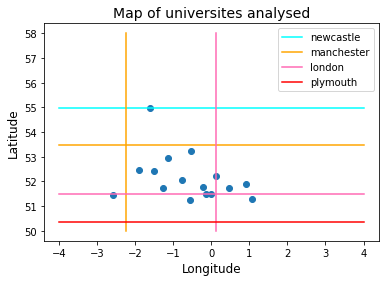

In [120]:

plt.scatter(lons_of_unis, lats_of_unis)

plt.plot(x, y_newcastle, color="aqua", label="newcastle")
plt.plot(x, y_manchester, color="orange", label="manchester")
plt.plot(x_manchester, y, color="orange")
plt.plot(x, y_lon, color="hotpink", label="london")
plt.plot(x_lon, y, color="hotpink")
plt.plot(x, y_plymouth, color="red", label="plymouth")
plt.legend(loc="upper right")

plt.xlabel("Longitude", size=12)
plt.ylabel("Latitude", size=12)
plt.title("Map of universites analysed", size=14)

plt.show()

As you can see, we have a higher representative in the East/South-East of the UK. Rarely any West, or North, representation.

Try displaying the percentages at each uni - Bubble Chart

Want a df with university, lat, lon, and the ratio - will do just for students for now
df = pd.DataFrame({
    'X': x,
    'Y': y,
    'Colors': colors,
    "bubble_size":area})

The lists have already been created above:
lats_of_unis - y-axis
lons_of_unis - x-axis
list_of_universities_analysed - just a key

We need the percentage

## Grads

In [121]:
list_of_unis_percentage_for_df_grads = df_grads['Percentage'].tolist()
number_of_bubbles = len(lons_of_unis)
colors = np.random.rand(number_of_bubbles)

In [122]:
percentages_multiplied_by_10_grads = [] #scaling the percentage to excentuate the differences
for percentage in list_of_unis_percentage_for_df_grads:
    five_times_percentage = percentage * 40
    percentages_multiplied_by_10_grads.append(five_times_percentage)

In [123]:
df_for_mapping_bigger_bubbles_grads = pd.DataFrame({
    'Unis': list_of_universities_analysed,
    'X': lons_of_unis,
    'Y': lats_of_unis,
    'Colors': colors,
    'Bubbles': percentages_multiplied_by_10_grads
})

Text(0.5, 1.0, 'Map of percentage of female grads \n at Universities analysed')

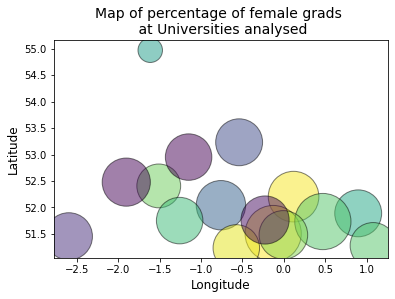

In [124]:
plt.scatter('X', 'Y',
            s='Bubbles',
            c='Colors',
            alpha=0.5,
            edgecolors='black',
            data=df_for_mapping_bigger_bubbles_grads)
plt.xlabel("Longitude", size=12)
plt.ylabel("Latitude", size=12)
plt.title("Map of percentage of female grads \n at Universities analysed", size=14)

## Mapping HESA Dataset analysis

### Top Ten Higher Education Providers by Number of First-year Enrolled Female Students

In [125]:
top_provider_1415_dict = {'The University of Manchester': 7855, 'University College London':6750, 'The University of Leeds': 6640, 'The Manchester Metropolitan University': 6175, 'King\'s College London':6085, 'The University of Birmingham': 5945, 'University of Nottingham':5655, 'University of the Arts, London':5535, 'The University of Sheffield':5420, 'Coventry University':5410}

top_provider_2021_dict = {'University College London':13705, 'The University of Manchester': 11130, 'King\'s College London': 10555, 'The University of Leeds': 8755,'The University of Birmingham':7765,'The Manchester Metropolitan University':7725,'Anglia Ruskin University':7505,
'The University of Sheffield':7415,'The Nottingham Trent University':7320,'Coventry University':7190}


In [126]:
list_1415_city = ['Manchester', 'London', 'Leeds', 'Manchester', 'London', 'Birmingham', 'Nottingham', 'London', 'Sheffield', 'Coventry']
list_2021_city = ['London', 'Manchester', 'London', 'Leeds', 'Birmingham', 'Manchester', 'Cambridge', 'Sheffield', 'Nottingham', 'Coventry']

14/15

In [127]:
lon_1415 = []
lat_1415 = []
for city in list_1415_city:
    lon_1415.append(get_lon_of_city(city))
    lat_1415.append(get_lat_of_city(city))

In [128]:
print(len(lon_1415))
print(len(lat_1415))
print(len(list_1415_city))

10
10
10


In [129]:
number_of_bubbles_here = len(lon_1415)
colors = np.random.rand(number_of_bubbles_here)

In [130]:
df_for_mapping_top_1415 = pd.DataFrame({
    'Unis': list_1415_city,
    'X': lon_1415,
    'Y': lat_1415,
    'Colors': colors
})

Text(0.5, 1.0, '14/15 Map Of Top Ten HE Providers by Number \n of First-year Enrolled Female Students')

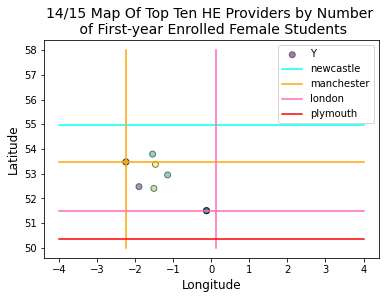

In [131]:
plt.scatter('X', 'Y',
            c='Colors',
            alpha=0.5,
            edgecolors='black',
            data=df_for_mapping_top_1415)

plt.plot(x, y_newcastle, color="aqua", label="newcastle")
plt.plot(x, y_manchester, color="orange", label="manchester")
plt.plot(x_manchester, y, color="orange")
plt.plot(x, y_lon, color="hotpink", label="london")
plt.plot(x_lon, y, color="hotpink")
plt.plot(x, y_plymouth, color="red", label="plymouth")
plt.legend(loc="upper right")

plt.xlabel("Longitude", size=12)
plt.ylabel("Latitude", size=12)
plt.title("14/15 Map Of Top Ten HE Providers by Number \n of First-year Enrolled Female Students", size=14)

20/21:

In [132]:
lon_2021 = []
lat_2021 = []
for city in list_2021_city:
    lon_2021.append(get_lon_of_city(city))
    lat_2021.append(get_lat_of_city(city))

In [133]:

number_of_bubbles_here = len(lon_2021)
colors = np.random.rand(number_of_bubbles_here)

Text(0.5, 1.0, '20/21 Map Of Top Ten HE Providers by Number \n of First-year Enrolled Female Students')

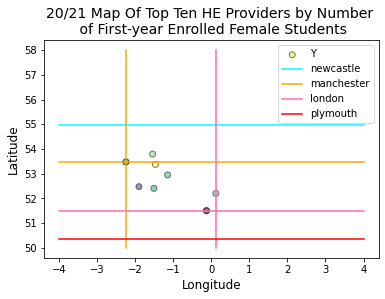

In [134]:
df_for_mapping_top_2021 = pd.DataFrame({
    'Unis': list_2021_city,
    'X': lon_2021,
    'Y': lat_2021,
    'Colors': colors,
})

plt.scatter('X', 'Y',
            c='Colors',
            alpha=0.5,
            edgecolors='black',
            data=df_for_mapping_top_2021)

plt.plot(x, y_newcastle, color="aqua", label="newcastle")
plt.plot(x, y_manchester, color="orange", label="manchester")
plt.plot(x_manchester, y, color="orange")
plt.plot(x, y_lon, color="hotpink", label="london")
plt.plot(x_lon, y, color="hotpink")
plt.plot(x, y_plymouth, color="red", label="plymouth")
plt.legend(loc="upper right")


plt.xlabel("Longitude", size=12)
plt.ylabel("Latitude", size=12)
plt.title("20/21 Map Of Top Ten HE Providers by Number \n of First-year Enrolled Female Students", size=14)

For comparison with all maps, we should create a map of the UK perhaps? Using the list we had above